In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules

In [2]:
df =  pd.read_parquet('logs.parquet')

# Reglas de asociación

## Filtrado y exploracion de los datos

Observación de cuantas piezas unicas hay en nuestro conjunto, descartando aquellas a las que pertenecen a un diseño no válido, y cuantas operaciones han habido.

In [3]:
añadir_pieza = df[(df['Evento'] == 'AÑADIR_PIEZA') & (df['diseñoid'] >= 1)].copy()
añadir_pieza = añadir_pieza[['pieza','diseñoid']]
print(añadir_pieza.head(10))
print(f"Número total de transacciones: {añadir_pieza['diseñoid'].nunique()}")
print(f"Número total de ítems (productos): {añadir_pieza['pieza'].nunique()}")

        pieza  diseñoid
1      M10749     88756
2       B1207     88755
6       TC102     88274
7       TC104     88274
8     SOF-022     88274
11      B407Z     88755
12  EE-VCR-01     88756
13      B607Z     88755
18     COL-02     88733
21     CNL082     88733
Número total de transacciones: 1694
Número total de ítems (productos): 6981


## Observación del tamaño de las transacciones

count    1694.000000
mean       12.605667
std        15.135197
min         1.000000
25%         3.000000
50%         8.000000
75%        17.000000
90%        29.000000
max       213.000000
Name: pieza, dtype: float64


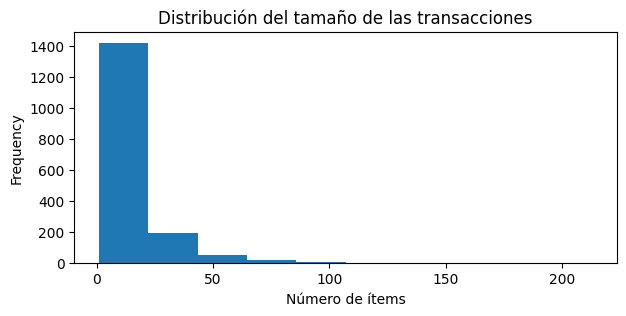

In [4]:
print(añadir_pieza.groupby('diseñoid')['pieza'].size().describe(percentiles=[.25, .5, .75, .9]))
fig, ax = plt.subplots(figsize=(7, 3))
añadir_pieza.groupby('diseñoid')['pieza'].size().plot.hist(ax=ax)
ax.set_title('Distribución del tamaño de las transacciones');
ax.set_xlabel('Número de ítems');

Podemos observar como la mayoría de los usuarios escogen entre 3 y 17 piezas, siendo una media de 12 piezas por diseño, además el 90% escogen menos de 29 piezas  

## Transformacion del dataframe en transacciones

In [5]:
transacciones = añadir_pieza.groupby('diseñoid')['pieza'].apply(list).to_list()
te = TransactionEncoder()
te_ary = te.fit(transacciones).transform(transacciones)
df_transacciones = pd.DataFrame(te_ary, columns=te.columns_)
df_transacciones.head(5)

,0070,030,0600,0600_G,0P120,100,1000,1001,1003,1004,...,Z-912,Z-922,ZK110,ZK120,ZK180,ZK75,ZN102,ZN140,ZN60,ZN74
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Aplicación del algoritmo apriori

Uso un soporte mínimio del 0.003 para que me genere las suficientes reglas para poder trabajar con ellas.

In [6]:
itemsets = apriori(df_transacciones, min_support=0.003, use_colnames=True)

Ordeno los itemsets por frecuencia de manera descendente

In [7]:

itemsets['n_items'] = itemsets['itemsets'].apply(len)
itemsets.sort_values(by='support', ascending=False)

,support,itemsets,n_items
181,0.111570,(EE-PILAR-01),1
191,0.094451,(EE-VCR-01),1
183,0.073790,(EE-RAD-01),1
273,0.072609,(SGE-001),1
83,0.060803,(ED-ALF-02),1
...,...,...,...
805,0.003542,"(ED-EST-01, SGE-004, EE-PILAR-01)",3
803,0.003542,"(EE-VCR-01, ED-EST-01, EE-PILAR-01)",3
820,0.003542,"(SGE-001, ED-PPC-08, EE-PILAR-01)",3
817,0.003542,"(EE-VCR-01, ED-PPC-01, SGE-001)",3


Filtro los itemsets que únicamente contienen un item

In [8]:
itemsets.query('n_items >= 2').sort_values('support', ascending=False)

,support,itemsets,n_items
714,0.023022,"(EE-VCR-01, EE-PILAR-01)",2
710,0.020071,"(EE-RAD-01, EE-PILAR-01)",2
728,0.018890,"(EE-VCR-01, EE-RAD-01)",2
615,0.017119,"(SGE-001, ED-PPC-02)",2
608,0.016529,"(SGE-001, ED-PPC-01)",2
...,...,...,...
346,0.003542,"(ED-COR-01, ED-ALF-02)",2
802,0.003542,"(ED-EST-01, EE-VBA-03, EE-PILAR-01)",3
803,0.003542,"(EE-VCR-01, ED-EST-01, EE-PILAR-01)",3
805,0.003542,"(ED-EST-01, SGE-004, EE-PILAR-01)",3


### Generación de las Reglas de Asociación

In [9]:
reglas = association_rules(itemsets, metric="confidence", min_threshold=0.1)
columnas = ['antecedents', 'consequents','support','confidence','lift']
reglas = reglas[columnas]
reglas.tail(10)


,antecedents,consequents,support,confidence,lift
936,"(MJ_INT, MJ_USB)",(MJ3654),0.003542,0.857143,207.428571
937,(MJ3654),"(MJ_INT, MJ_USB)",0.003542,0.857143,207.428571
938,(MJ_INT),"(MJ3654, MJ_USB)",0.003542,0.545455,154.000000
939,(MJ_USB),"(MJ3654, MJ_INT)",0.003542,0.666667,188.222222
940,"(SOF-014, SOF-013)",(SOF-015),0.003542,0.750000,90.750000
941,"(SOF-014, SOF-015)",(SOF-013),0.003542,0.750000,66.868421
942,"(SOF-013, SOF-015)",(SOF-014),0.003542,0.750000,84.700000
943,(SOF-014),"(SOF-013, SOF-015)",0.003542,0.400000,84.700000
944,(SOF-013),"(SOF-014, SOF-015)",0.003542,0.315789,66.868421
945,(SOF-015),"(SOF-014, SOF-013)",0.003542,0.428571,90.750000


### Filtrado de reglas

In [10]:
reglas_support = reglas[reglas['support'] > 0.003]
reglas_support

,antecedents,consequents,support,confidence,lift
0,(1101),(SGE-004),0.003542,0.545455,12.320000
1,(1536),(EE-RAD-01),0.003542,0.461538,6.254769
2,(4401),(ED-TVT-02),0.004723,0.533333,10.384674
3,(4401),(EE-PILAR-01),0.003542,0.400000,3.585185
4,(4401),(SOF-022),0.004132,0.466667,21.365766
...,...,...,...,...,...
941,"(SOF-014, SOF-015)",(SOF-013),0.003542,0.750000,66.868421
942,"(SOF-013, SOF-015)",(SOF-014),0.003542,0.750000,84.700000
943,(SOF-014),"(SOF-013, SOF-015)",0.003542,0.400000,84.700000
944,(SOF-013),"(SOF-014, SOF-015)",0.003542,0.315789,66.868421


In [11]:
reglas_antecentes = reglas_support[reglas_support['antecedents'].apply(lambda x: len(x) > 1)]
reglas_antecentes.head(10)

,antecedents,consequents,support,confidence,lift
668,"(ED-LPR-02, CAM-02)",(EE-PILAR-01),0.003542,0.666667,5.975309
669,"(ED-LPR-02, EE-PILAR-01)",(CAM-02),0.003542,0.375000,12.216346
670,"(CAM-02, EE-PILAR-01)",(ED-LPR-02),0.003542,0.428571,12.517241
673,"(ED-EST-01, ED-ALF-02)",(ED-TVT-02),0.004132,0.466667,9.086590
674,"(ED-EST-01, ED-TVT-02)",(ED-ALF-02),0.004132,0.538462,8.855863
675,"(ED-ALF-02, ED-TVT-02)",(ED-EST-01),0.004132,0.350000,6.737500
676,"(ED-LPR-01, ED-PLA-22)",(ED-ALF-02),0.003542,0.666667,10.964401
677,"(ED-LPR-01, ED-ALF-02)",(ED-PLA-22),0.003542,0.352941,23.915294
678,"(ED-PLA-22, ED-ALF-02)",(ED-LPR-01),0.003542,0.545455,27.176471
681,"(ED-LPR-01, ED-ALF-02)",(ED-TVT-01),0.004723,0.470588,11.071895


In [12]:
reglas_antecentes.sort_values(by = 'lift', ascending = False).head(10)

,antecedents,consequents,support,confidence,lift
928,"(MJ2509, MJ2511)",(MJ2510),0.003542,1.000000,242.000000
930,"(MJ2511, MJ2510)",(MJ2509),0.003542,1.000000,211.750000
936,"(MJ_INT, MJ_USB)",(MJ3654),0.003542,0.857143,207.428571
929,"(MJ2509, MJ2510)",(MJ2511),0.003542,0.857143,207.428571
934,"(MJ3654, MJ_INT)",(MJ_USB),0.003542,1.000000,188.222222
935,"(MJ3654, MJ_USB)",(MJ_INT),0.003542,1.000000,154.000000
884,"(EE-INT-01, EE-VBA-03)",(EE-ENC-01),0.003542,0.666667,94.111111
940,"(SOF-014, SOF-013)",(SOF-015),0.003542,0.750000,90.750000
942,"(SOF-013, SOF-015)",(SOF-014),0.003542,0.750000,84.700000
758,"(ED-BAN-01, ED-TVT-01)",(ED-BAN-02),0.003542,0.857143,80.666667


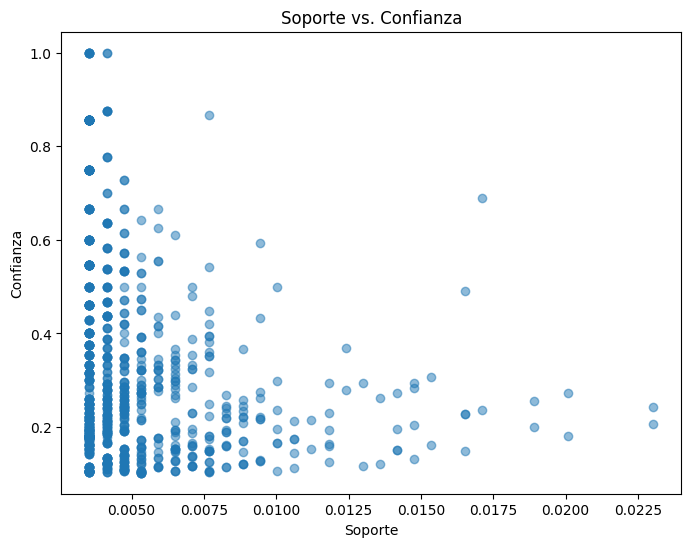

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(reglas['support'], reglas['confidence'], alpha=0.5)
plt.title('Soporte vs. Confianza')
plt.xlabel('Soporte')
plt.ylabel('Confianza')
plt.show()

In [14]:
# Visualizar soporte vs lift o confianza vs lift
reglas.nunique()

antecedents    241
consequents    149
support         26
confidence     250
lift           626
dtype: int64

## Recomendador de piezas

In [15]:
def recomendar_piezas(piezas_usuario, reglas, top_n=5):
    reglas_validas = reglas[reglas['antecedents'].apply(lambda x: x.issubset(piezas_usuario))]
    
    reglas_validas = reglas_validas.sort_values(['confidence', 'lift'], ascending=False)
    

    piezas_recomendadas = []
    for consequents in reglas_validas['consequents']:
        for pieza in consequents:
            if pieza not in piezas_usuario and pieza not in piezas_recomendadas:
                piezas_recomendadas.append(pieza)
                if len(piezas_recomendadas) >= top_n:
                    return piezas_recomendadas
    return piezas_recomendadas

In [17]:
piezas_usuario = {'ED-PPC-02'}
recomendaciones = recomendar_piezas(piezas_usuario, reglas, top_n=6)

print("Piezas recomendadas:", recomendaciones)

Piezas recomendadas: ['SGE-001', 'EE-PILAR-01', 'SGE-004', 'ED-EST-01', 'EE-VCR-01', 'ED-LIB-11']
